# Free Energy Estimation

Estimate the free energy surface of alanine dipeptide from MD sampling.
This notebook covers:
- Histogram-based free energy from Langevin MD
- Convergence analysis: how much sampling is enough?
- `log_boltzmann_regularized` for handling high-energy configurations
- Connection to normalizing flow training (the FAB paper motivation)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as random

from openmm import unit
from openmmtools import testsystems

import jaxmm
from jaxmm import FEMTOSECOND, KB
from jaxmm.notebook import free_energy_1d, free_energy_2d

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
# Implicit solvent system (matches FAB paper setup)
aldp = testsystems.AlanineDipeptideImplicit(constraints=None)
params = jaxmm.extract_params(aldp.system)
pos0 = jnp.array(aldp.positions.value_in_unit(unit.nanometer), dtype=jnp.float64)
pos_min = jaxmm.minimize_energy(pos0, params)

temperature = 300.0
kBT = KB * temperature

# Thermalize
result = jaxmm.langevin_baoab(
    pos_min, jnp.zeros_like(pos_min), params,
    dt=1.0 * FEMTOSECOND, temperature=temperature, friction=1.0,
    n_steps=5000, key=random.key(0),
)
pos_therm = result.positions
vel_therm = result.velocities

print(f"ALDP implicit: {params.n_atoms} atoms, GBSA = {params.gbsa is not None}")

ALDP implicit: 22 atoms, GBSA = True


## Long production run

500 ps at 300K. We save frequently to study convergence.

In [3]:
n_steps = 500000  # 500 ps
save_every = 50   # save every 50 fs -> 10000 frames

result = jax.jit(
    jaxmm.langevin_baoab, static_argnames=("n_steps", "save_every")
)(
    pos_therm, vel_therm, params,
    dt=1.0 * FEMTOSECOND, temperature=temperature, friction=1.0,
    n_steps=n_steps, save_every=save_every, key=random.key(42),
)
traj = result.trajectory_positions

# Discard first 10% as warmup
warmup = traj.shape[0] // 10
traj = traj[warmup:]

# Compute dihedrals and energies for all frames
phi_idx = jnp.array(jaxmm.phi_indices(aldp.topology))
psi_idx = jnp.array(jaxmm.psi_indices(aldp.topology))

phi = np.degrees(np.array(jaxmm.dihedral_angle(traj, phi_idx)[:, 0]))
psi = np.degrees(np.array(jaxmm.dihedral_angle(traj, psi_idx)[:, 0]))

print(f"Production frames: {traj.shape[0]} (after warmup)")

Production frames: 9000 (after warmup)


## 2D free energy surface

F(phi, psi) = -kBT ln P(phi, psi) estimated from the sampled distribution.

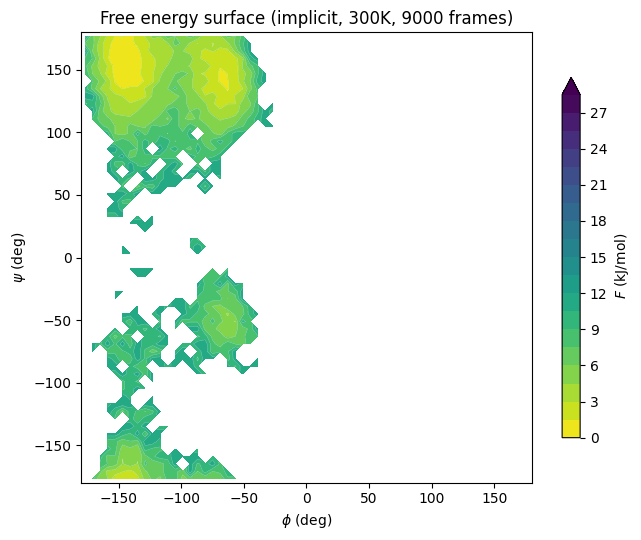

In [4]:
phi_c, psi_c, fe_2d = free_energy_2d(
    phi, psi, temperature, bins=60, sample_range=[(-180, 180), (-180, 180)],
)
PHI, PSI = np.meshgrid(phi_c, psi_c)

fig, ax = plt.subplots(figsize=(7, 5.5))
levels = np.arange(0, 30, 1.5)
cf = ax.contourf(PHI, PSI, fe_2d.T, levels=levels, cmap="viridis_r", extend="max")
ax.contour(PHI, PSI, fe_2d.T, levels=levels, colors="white", linewidths=0.3, alpha=0.5)
ax.set_xlabel(r"$\phi$ (deg)")
ax.set_ylabel(r"$\psi$ (deg)")
ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)
ax.set_aspect("equal")
ax.set_title(f"Free energy surface (implicit, {temperature:.0f}K, {traj.shape[0]} frames)")
plt.colorbar(cf, ax=ax, label=r"$F$ (kJ/mol)", shrink=0.8)
plt.tight_layout()
plt.show()

## Convergence analysis

How does the free energy estimate improve with more sampling?
We compute F(phi) using increasing fractions of the trajectory
and overlay the results.

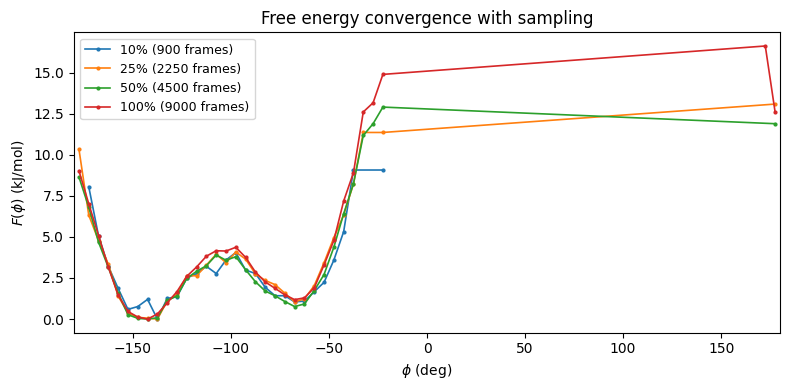

In [5]:
fractions = [0.1, 0.25, 0.5, 1.0]
n_total = len(phi)

fig, ax = plt.subplots(figsize=(8, 4))

for frac in fractions:
    n = int(n_total * frac)
    centers, fe = free_energy_1d(phi[:n], temperature, bins=72, sample_range=(-180, 180))
    valid = ~np.isnan(fe)
    ax.plot(centers[valid], fe[valid], "o-", ms=2, lw=1.2,
            label=f"{frac:.0%} ({n} frames)")

ax.set_xlabel(r"$\phi$ (deg)")
ax.set_ylabel(r"$F(\phi)$ (kJ/mol)")
ax.set_xlim(-180, 180)
ax.set_title("Free energy convergence with sampling")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

## Block averaging: statistical uncertainty

Split the trajectory into blocks, compute F(phi) from each block,
and estimate the standard error.

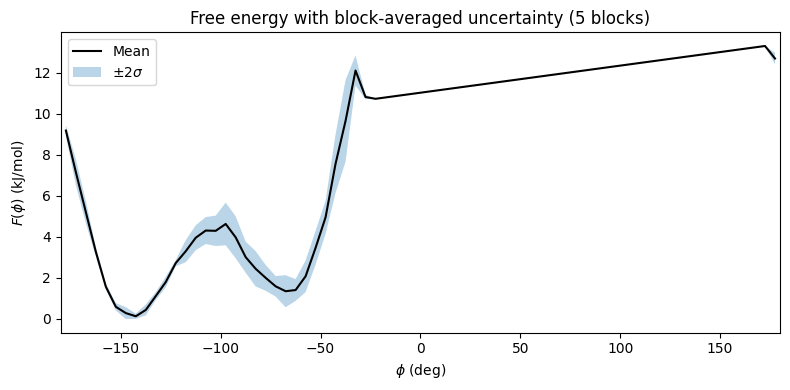

In [6]:
n_blocks = 5
block_size = n_total // n_blocks

fe_blocks = []
for b in range(n_blocks):
    phi_block = phi[b * block_size : (b + 1) * block_size]
    _, fe_b = free_energy_1d(phi_block, temperature, bins=72, sample_range=(-180, 180))
    fe_blocks.append(fe_b)

fe_blocks = np.array(fe_blocks)
fe_mean = np.nanmean(fe_blocks, axis=0)
fe_std = np.nanstd(fe_blocks, axis=0) / np.sqrt(n_blocks)  # standard error

centers, _ = free_energy_1d(phi, temperature, bins=72, sample_range=(-180, 180))

fig, ax = plt.subplots(figsize=(8, 4))
valid = ~np.isnan(fe_mean)
ax.plot(centers[valid], fe_mean[valid], "k-", lw=1.5, label="Mean")
ax.fill_between(
    centers[valid],
    fe_mean[valid] - 2 * fe_std[valid],
    fe_mean[valid] + 2 * fe_std[valid],
    alpha=0.3, label=r"$\pm 2\sigma$",
)
ax.set_xlabel(r"$\phi$ (deg)")
ax.set_ylabel(r"$F(\phi)$ (kJ/mol)")
ax.set_xlim(-180, 180)
ax.set_title(f"Free energy with block-averaged uncertainty ({n_blocks} blocks)")
ax.legend()
plt.tight_layout()
plt.show()

## log_boltzmann_regularized

When training generative models (normalizing flows, diffusion models) against
the Boltzmann distribution, the model sometimes proposes configurations with
extremely high energy (e.g., atom clashes). The standard log-Boltzmann factor
`-E/kBT` becomes extremely negative, causing numerical instability.

`log_boltzmann_regularized` handles this via:
- Below `energy_cut`: energy reported as-is
- Above `energy_cut`: energy grows logarithmically (soft cap)
- Above `energy_max`: hard clamp

This keeps gradients well-behaved during training.

In [7]:
# Generate some configurations spanning a wide energy range:
# low-energy (from MD) + high-energy (random perturbations)
n_low = 200
n_high = 200

# Low-energy: sample from MD trajectory
indices = np.linspace(0, len(traj) - 1, n_low, dtype=int)
pos_low = traj[indices]

# High-energy: add random noise to positions (simulates bad generative model samples)
key = random.key(123)
noise = 0.1 * random.normal(key, (n_high,) + pos_min.shape)  # 0.1 nm noise
pos_high = pos_min[None, :, :] + noise

all_pos = jnp.concatenate([pos_low, pos_high], axis=0)

# Standard log-Boltzmann
vmap_lb = jax.jit(jax.vmap(jaxmm.log_boltzmann, in_axes=(0, None, None)))
log_b_standard = np.array(vmap_lb(all_pos, params, temperature))

# Regularized log-Boltzmann
energy_cut = 100.0   # kBT units: start dampening above 100 kBT
energy_max = 1000.0  # kBT units: hard clamp

vmap_lbr = jax.jit(jax.vmap(jaxmm.log_boltzmann_regularized, in_axes=(0, None, None, None, None)))
log_b_reg = np.array(vmap_lbr(all_pos, params, temperature, energy_cut, energy_max))

print(f"Standard log_boltzmann range: [{log_b_standard.min():.0f}, {log_b_standard.max():.1f}]")
print(f"Regularized range:            [{log_b_reg.min():.0f}, {log_b_reg.max():.1f}]")

Standard log_boltzmann range: [-969953021934419, 53.1]
Regularized range:            [-135, 53.1]


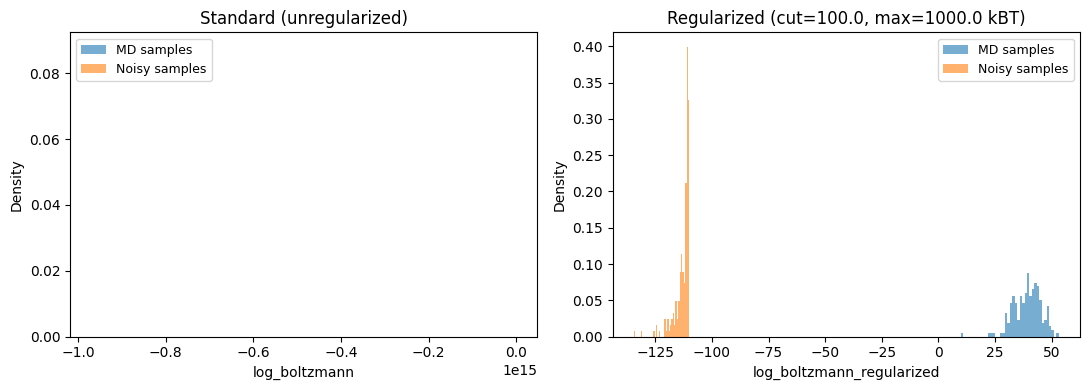

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# Compare distributions
ax1.hist(log_b_standard[:n_low], bins=40, alpha=0.6, label="MD samples", density=True)
ax1.hist(log_b_standard[n_low:], bins=40, alpha=0.6, label="Noisy samples", density=True)
ax1.set_xlabel("log_boltzmann")
ax1.set_ylabel("Density")
ax1.set_title("Standard (unregularized)")
ax1.legend(fontsize=9)

ax2.hist(log_b_reg[:n_low], bins=40, alpha=0.6, label="MD samples", density=True)
ax2.hist(log_b_reg[n_low:], bins=40, alpha=0.6, label="Noisy samples", density=True)
ax2.set_xlabel("log_boltzmann_regularized")
ax2.set_ylabel("Density")
ax2.set_title(f"Regularized (cut={energy_cut}, max={energy_max} kBT)")
ax2.legend(fontsize=9)

plt.tight_layout()
plt.show()

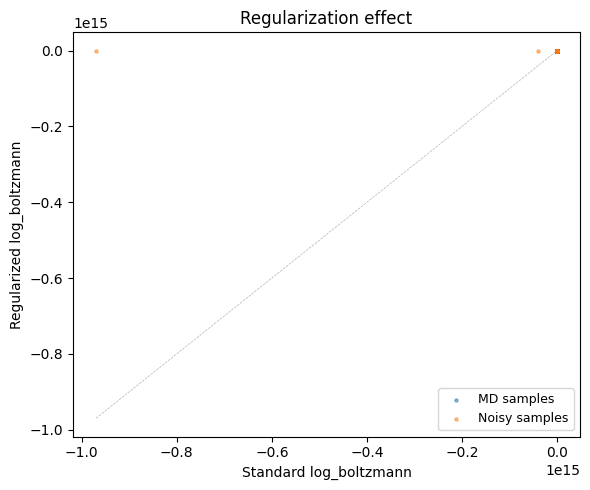

For low-energy (physical) samples, both agree.
For high-energy samples, regularization caps the penalty.


In [9]:
# Scatter: standard vs regularized
fig, ax = plt.subplots(figsize=(6, 5))
ax.scatter(log_b_standard[:n_low], log_b_reg[:n_low], s=5, alpha=0.5, label="MD samples")
ax.scatter(log_b_standard[n_low:], log_b_reg[n_low:], s=5, alpha=0.5, label="Noisy samples")

# Identity line
lo = min(log_b_standard.min(), log_b_reg.min())
hi = max(log_b_standard.max(), log_b_reg.max())
ax.plot([lo, hi], [lo, hi], "k--", lw=0.5, alpha=0.3)

ax.set_xlabel("Standard log_boltzmann")
ax.set_ylabel("Regularized log_boltzmann")
ax.set_title("Regularization effect")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print("For low-energy (physical) samples, both agree.")
print("For high-energy samples, regularization caps the penalty.")

## Connection to normalizing flow training

jaxmm was built to provide the Boltzmann target for training normalizing
flows (e.g., [FAB](https://github.com/lollcat/fab-torch)). The key ingredients:

1. **`log_boltzmann(x, params, T)`**: the unnormalized log-density of the
   Boltzmann distribution, used as the training target.

2. **`jax.grad(log_boltzmann)`**: gradients w.r.t. x for score-based training
   or force-matching.

3. **`jax.vmap`**: batch evaluation of log-densities for all samples in a
   training batch.

4. **`log_boltzmann_regularized`**: numerical stability for early-training
   samples that land in high-energy regions.

5. **`save_params` / `load_params`**: serialize the force field once, load
   on training machines without OpenMM.

The typical training loop:
```python
# Forward KL: train flow to match Boltzmann target
z = flow.sample(batch_size, key)           # samples from flow
log_q = flow.log_prob(z)                    # flow log-density
log_p = vmap_log_boltzmann(z, params, T)    # Boltzmann log-density
loss = (log_q - log_p).mean()               # forward KL
```

In [10]:
# Demonstrate the training-relevant functions

# 1. Batch log-Boltzmann evaluation
batch_size = 100
batch_pos = traj[:batch_size]
log_p = vmap_lb(batch_pos, params, temperature)
print(f"Batch log_boltzmann: shape={log_p.shape}, mean={float(log_p.mean()):.2f}")

# 2. Score function: d(log p)/dx
score_fn = jax.jit(jax.vmap(jax.grad(jaxmm.log_boltzmann), in_axes=(0, None, None)))
scores = score_fn(batch_pos, params, temperature)
print(f"Batch scores: shape={scores.shape}")
print(f"  RMS score magnitude: {float(jnp.sqrt(jnp.mean(scores**2))):.4f}")

# 3. These compose naturally: grad of regularized version
score_reg = jax.jit(jax.vmap(
    jax.grad(jaxmm.log_boltzmann_regularized),
    in_axes=(0, None, None, None, None),
))
scores_r = score_reg(batch_pos, params, temperature, energy_cut, energy_max)
print(f"  RMS regularized score: {float(jnp.sqrt(jnp.mean(scores_r**2))):.4f}")

Batch log_boltzmann: shape=(100,), mean=36.17
Batch scores: shape=(100, 22, 3)
  RMS score magnitude: 342.8957
  RMS regularized score: 342.8957
